In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import tensorboard

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

/home/tarobben/.conda/envs/detectron2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
image = cv2.imread('/home/tarobben/scratch/RCNN/PFO_png/1006_70/1006_70_slice_000.png')
cv2.imshow('lol', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

In [11]:
# Replace with your dataset name
dataset_name = ["pfo_single"]
for dataset_name in dataset_name:
    # Remove from DatasetCatalog
    if dataset_name in DatasetCatalog.list():
        DatasetCatalog.remove(dataset_name)

    # Remove from MetadataCatalog
    if dataset_name in MetadataCatalog.list():
        MetadataCatalog.remove(dataset_name)


In [12]:
def get_my_dataset_dicts(img_dir, annotation_json):
    with open(annotation_json) as f:
        coco = json.load(f)

    image_id_to_file = {img["id"]: img["file_name"] for img in coco["images"]}
    image_id_to_size = {img["id"]: (img["height"], img["width"]) for img in coco["images"]}

    dataset_dicts = []
    for img_id, file_name in image_id_to_file.items():
        record = {}
        record["file_name"] = os.path.join(img_dir, file_name)
        record["image_id"] = img_id
        height, width = image_id_to_size[img_id]
        record["height"] = height
        record["width"] = width

        record["annotations"] = []
        for ann in coco["annotations"]:
            if ann["image_id"] != img_id:
                continue

            obj = {
                "bbox": ann["bbox"],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": ann["category_id"]
            }
            record["annotations"].append(obj)

        dataset_dicts.append(record)

    return dataset_dicts


DatasetCatalog.register("pfo_single", lambda: get_my_dataset_dicts('/home/tarobben/scratch/RCNN/PFO_png/', '/home/tarobben/scratch/RCNN/pfo_single.json' ))

MetadataCatalog.get("pfo_single").thing_classes = ["ROI"]

In [ ]:
# Get dataset
dataset_dicts = DatasetCatalog.get("pfo_train")
metadata = MetadataCatalog.get("pfo_train")

# Show 3 random images with bounding boxes
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])

    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)

    # If you're in a notebook (e.g., Jupyter), use this:
    from IPython.display import display
    from PIL import Image
    display(Image.fromarray(out.get_image()[:, :, ::-1]))

In [15]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pfo_single",)
cfg.DATASETS.TEST = ()  # or ("pfo_val",) if you registered a validation set
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16, 32, 64]]  # Good range for your box sizes
cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.75, 1.0, 1.5]]  # Covers your range nicely
# cfg.MODEL.FPN.IN_FEATURES = ["p2" "p3", "p4"]
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # you only have one class ("ROI")

cfg.OUTPUT_DIR = "/home/tarobben/scratch/RCNN/output_pfo_overfit/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[04/16 10:04:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (36, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible s

[04/16 10:04:24 d2.engine.train_loop]: Starting training from iteration 0
[04/16 10:04:39 d2.utils.events]:  eta: 0:11:25  iter: 19  total_loss: 1.421  loss_cls: 0.6562  loss_box_reg: 0.0006283  loss_rpn_cls: 0.7297  loss_rpn_loc: 0.03593  time: 0.6979  data_time: 0.0574  lr: 4.9953e-06  max_mem: 8436M
[04/16 10:04:52 d2.utils.events]:  eta: 0:10:46  iter: 39  total_loss: 1.123  loss_cls: 0.3604  loss_box_reg: 0.0004512  loss_rpn_cls: 0.7128  loss_rpn_loc: 0.03778  time: 0.6943  data_time: 0.0073  lr: 9.9902e-06  max_mem: 8436M
[04/16 10:05:07 d2.utils.events]:  eta: 0:11:23  iter: 59  total_loss: 0.8435  loss_cls: 0.1353  loss_box_reg: 0.0002875  loss_rpn_cls: 0.6795  loss_rpn_loc: 0.03418  time: 0.7017  data_time: 0.0082  lr: 1.4985e-05  max_mem: 8436M
[04/16 10:05:21 d2.utils.events]:  eta: 0:11:10  iter: 79  total_loss: 0.7329  loss_cls: 0.07445  loss_box_reg: 0.0001301  loss_rpn_cls: 0.6239  loss_rpn_loc: 0.02992  time: 0.7030  data_time: 0.0070  lr: 1.998e-05  max_mem: 8436M
[04/

In [13]:
# Look at training curves in tensorboard:
%reload_ext tensorboard
%tensorboard --logdir output_pfo

Launching TensorBoard...

In [16]:
# Get dataset
dataset_dicts = DatasetCatalog.get("pfo_single")
metadata = MetadataCatalog.get("pfo_single")
print(dataset_dicts)
predictor = DefaultPredictor(cfg)
print(predictor)
evaluator = COCOEvaluator("pfo_single", output_dir="/home/tarobben/scratch/RCNN/")
val_loader = build_detection_test_loader(cfg, "pfo_single")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[{'file_name': '/home/tarobben/scratch/RCNN/PFO_png/1172_70/1172_70_slice_165.png', 'image_id': 1815, 'height': 512, 'width': 512, 'annotations': [{'bbox': [130.73934061023886, 245.52601846139544, 31.115643527243606, 23.656459170959124], 'bbox_mode': <BoxMode.XYWH_ABS: 1>, 'category_id': 0}]}]


Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.weight' to the model due to incompatible shapes: (3, 256, 1, 1) in the checkpoint but (9, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.objectness_logits.bias' to the model due to incompatible shapes: (3,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.weight' to the model due to incompatible shapes: (12, 256, 1, 1) in the checkpoint but (36, 256, 1, 1) in the model! You might want to double check if this is expected.
Skip loading parameter 'proposal_generator.rpn_head.anchor_deltas.bias' to the model due to incompatible shapes: (12,) in the checkpoint but (36,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible s

[04/16 10:21:22 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/16 10:21:22 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[04/16 10:21:22 d2.data.common]: Serialized dataset takes 0.00 MiB
[04/16 10:21:22 d2.evaluation.evaluator]: Start inference on 1 batches
[04/16 10:21:23 d2.evaluation.evaluator]: Inference done 1/1. Dataloading: 0.0000 s/iter. Inference: 0.0842 s/iter. Eval: 0.0005 s/iter. Total: 0.0847 s/iter. ETA=0:00:00
[04/16 10:21:23 d2.evaluation.evaluator]: Total inference time: 0:00:00.261711 (0.261711 s / iter per device, on 1 devices)
[04/16 10:21:23 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.084179 s / iter per device, on 1 devices)
[04/16 10:21:23 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[04/16 10:21:23 d2.evaluation.coco_evaluation]: Saving results to /ho

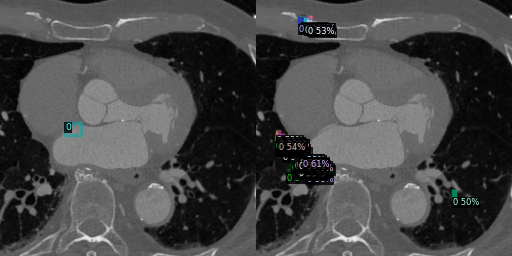

In [17]:
import cv2
import json
import os
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from PIL import Image
from IPython.display import display

# Load COCO val JSON
with open("/home/tarobben/scratch/RCNN/pfo_single.json") as f:
    val_json = json.load(f)

# Image you want to test (use one you know has a bbox)
# Find a val image that actually has a bounding box
annotated_image_ids = set([ann["image_id"] for ann in val_json["annotations"]])
annotated_images = [img for img in val_json["images"] if img["id"] in annotated_image_ids]


image_info = random.choice(annotated_images)
image_path = os.path.join("/home/tarobben/scratch/RCNN/PFO_png/", image_info["file_name"])
image_id = image_info["id"]
image = cv2.imread(image_path)

# Get ground truth annotations for this image
gt_annos = [a for a in val_json["annotations"] if a["image_id"] == image_id]

# Convert to Detectron2-style instances
gt_record = {
    "file_name": image_path,
    "image_id": image_id,
    "height": image.shape[0],
    "width": image.shape[1],
    "annotations": []
}

for ann in gt_annos:
    x, y, w, h = ann["bbox"]
    gt_record["annotations"].append({
        "bbox": [x, y, w, h],
        "bbox_mode": BoxMode.XYWH_ABS,
        "category_id": ann["category_id"]
    })

# Visualize ground truth
v_gt = Visualizer(image[:, :, ::-1],
                  metadata=MetadataCatalog.get("pfo_val"),
                  scale=0.5,
                  instance_mode=ColorMode.IMAGE_BW)

img_gt = v_gt.draw_dataset_dict(gt_record).get_image()[:, :, ::-1]

# Run prediction
outputs = predictor(image)
v_pred = Visualizer(image[:, :, ::-1],
                    metadata=MetadataCatalog.get("pfo_val"),
                    scale=0.5)

img_pred = v_pred.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()[:, :, ::-1]

# Show side by side
combined = cv2.hconcat([img_gt, img_pred])
Image.fromarray(combined)


Anchors


In [85]:


with open("/home/tarobben/scratch/RCNN/PFO_png/pfo_coco.json") as f:
    data = json.load(f)

widths = []
heights = []
ratios = []

for ann in data["annotations"]:
    _, _, w, h = ann["bbox"]
    widths.append(w)
    heights.append(h)
    ratios.append(w / h)

print("Width range:", min(widths), "-", max(widths))
print("Height range:", min(heights), "-", max(heights))
print("Aspect ratio range:", min(ratios), "-", max(ratios))

Width range: 20.431860999391688 - 60.952380952380906
Height range: 20.72063452691009 - 43.39224415955971
Aspect ratio range: 0.7894736842105258 - 1.863883140404199


In [17]:
image = cv2.imread("/home/tarobben/scratch/RCNN/PFO_png/2103_70/2103_70_slice_097.png")
outputs = predictor(image)
v = Visualizer(image[:, :, ::-1], MetadataCatalog.get("pfo_val"))
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2.imshow("Predictions", out.get_image()[:, :, ::-1])
cv2.waitKey(0)


235